#### STEP 1. Patient Segmentation

In [52]:
# define patient

import pandas as pd

patients = pd.read_csv("C:/Users/ooluw/Downloads/MedOptix/med_env/medoptix_data/patients.csv")
sessions = pd.read_csv("C:/Users/ooluw/Downloads/MedOptix/med_env/medoptix_data/sessions.csv")
feedback = pd.read_csv("C:/Users/ooluw/Downloads/MedOptix/med_env/medoptix_data/feedback.csv")
interventions = pd.read_csv("C:/Users/ooluw/Downloads/MedOptix/med_env/medoptix_data/interventions.csv")
clinics = pd.read_csv("C:/Users/ooluw/Downloads/MedOptix/med_env/medoptix_data/clinics.csv")    
dropout_flags = pd.read_csv("C:/Users/ooluw/Downloads/MedOptix/med_env/medoptix_data/dropout_flags.csv")

In [53]:
# step 1b --- Define the sessions the patients had in relations to the therapy (EXTRA FEATURE ENGINEERING)-- Dynamic dataset

sess_agg = (
    sessions
    .sort_values(['patient_id', 'date'])    # putting every patient session in calender mode
    .assign(pain_delta=lambda d: (d.groupby("patient_id")["pain_level"].diff() # create a new column help save change in new pain level
    ))
    .groupby("patient_id") #grouped by patient ID -- collect all the rows belonging to each patient
    .agg (
        n_sessions = ("session_id", "count"),           # defining some extra insights into the session data
        avg_session_duration = ("duration", "mean"),
        first_week = ("week", "min"),
        last_week = ("week", "max"),
        mean_pain = ("pain_level", "mean"),
        mean_pain_delta = ("pain_delta", "mean"),
        home_adherence_mean = ("home_adherence_pc", "mean"),
        satisfaction_mean = ("satisfaction", "mean")
    )
)

sess_agg.head(3)

,n_sessions,avg_session_duration,first_week,last_week,mean_pain,mean_pain_delta,home_adherence_mean,satisfaction_mean
patient_id,,,,,,,,
1,20,41.750000,1,12,2.150000,-0.263158,77.750000,6.500000
2,8,33.875000,1,11,2.250000,-0.571429,61.625000,7.000000
3,17,41.470588,1,12,2.470588,-0.312500,73.705882,5.941176


In [54]:
# step 1c Define the patients (static dataset)
pat_sel = patients.set_index("patient_id")

pat_sel.head(3)

,age,gender,bmi,smoker,chronic_cond,injury_type,signup_date,referral_source,consent,clinic_id,insurance_type
patient_id,,,,,,,,,,,
1,29,Male,23.9,False,NaN,Knee,2025-04-27 00:12:44.286283,Insurance,True,6,Public
2,68,Female,31.7,True,NaN,Shoulder,2024-11-28 00:12:44.286283,Insurance,False,3,Public
3,64,Male,27.5,False,NaN,Hip,2024-10-10 00:12:44.286283,GP,True,5,Public


In [55]:

# step 1d -- join static dataset + dynamice (Behvaioral features)

X_raw = pat_sel.join(sess_agg, how="left")
X_raw.head(3)
         

,age,gender,bmi,smoker,chronic_cond,injury_type,signup_date,referral_source,consent,clinic_id,insurance_type,n_sessions,avg_session_duration,first_week,last_week,mean_pain,mean_pain_delta,home_adherence_mean,satisfaction_mean
patient_id,,,,,,,,,,,,,,,,,,,
1,29,Male,23.9,False,NaN,Knee,2025-04-27 00:12:44.286283,Insurance,True,6,Public,20,41.750000,1,12,2.150000,-0.263158,77.750000,6.500000
2,68,Female,31.7,True,NaN,Shoulder,2024-11-28 00:12:44.286283,Insurance,False,3,Public,8,33.875000,1,11,2.250000,-0.571429,61.625000,7.000000
3,64,Male,27.5,False,NaN,Hip,2024-10-10 00:12:44.286283,GP,True,5,Public,17,41.470588,1,12,2.470588,-0.312500,73.705882,5.941176


In [56]:
print(patients.columns.tolist())


['patient_id', 'age', 'gender', 'bmi', 'smoker', 'chronic_cond', 'injury_type', 'signup_date', 'referral_source', 'consent', 'clinic_id', 'insurance_type']


In [58]:
# step 1e Label engineering & encoding 

# patient static attributes ----- define what describes a patient
pat_sel = patients[
    [
        "patient_id",
        "age",
        "gender",
        "bmi",
        "smoker",
        "chronic_cond",
        "injury_type",
        "referral_source",
        "insurance_type"
    ]
].set_index("patient_id")


# label engineering (attach the drop out flags to the patient)
# use labels as your source of truth which we'd later use in prediction (who dropped out or not)
label = dropout_flags.set_index("patient_id").dropout 

In [59]:
X_raw.head(2)

,age,gender,bmi,smoker,chronic_cond,injury_type,signup_date,referral_source,consent,clinic_id,insurance_type,n_sessions,avg_session_duration,first_week,last_week,mean_pain,mean_pain_delta,home_adherence_mean,satisfaction_mean
patient_id,,,,,,,,,,,,,,,,,,,
1,29,Male,23.9,False,NaN,Knee,2025-04-27 00:12:44.286283,Insurance,True,6,Public,20,41.750,1,12,2.15,-0.263158,77.750,6.5
2,68,Female,31.7,True,NaN,Shoulder,2024-11-28 00:12:44.286283,Insurance,False,3,Public,8,33.875,1,11,2.25,-0.571429,61.625,7.0


In [60]:
#step 1f  Data Pipeline --- compress all your data preprocessing step into one pipeline 

# step 1f-i -- Define your numeric columns and Categorical columns (non-numeric)


# looking out for high dimensions in your data 
# looking out for  density of your data
num_col = [                                  # manual dimension reduction is as a result of your correlation analyis
    "age", "bmi",
    "n_sessions", "avg_session_duration",
    "mean_pain", "mean_pain_delta"
]

cat_col = [
    "gender", "smoker",
    "chronic_cond", "injury_type"
]

X_raw[cat_col].astype("string")  # casting categorical data

,gender,smoker,chronic_cond,injury_type
patient_id,,,,
1,Male,False,<NA>,Knee
2,Female,True,<NA>,Shoulder
3,Male,False,<NA>,Hip
4,Female,False,<NA>,Back
5,Female,False,<NA>,Shoulder
...,...,...,...,...
4996,Female,True,Diabetes,Back
4997,Female,False,<NA>,Shoulder
4998,Female,False,<NA>,Back


In [61]:
# step 1g - Preprocessing with the pipeline 
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, RobustScaler
from sklearn.impute import SimpleImputer

from sklearn.compose import ColumnTransformer


numeric_pipe = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="median")),
        ("scalar", RobustScaler())
    ]
)



categorical_pipe = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("onhot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
    ]
)

In [62]:
#### Column Transformer 

preproc = ColumnTransformer(
    transformers= [
        ("num", numeric_pipe, num_col),
        ("cat", categorical_pipe, cat_col)
    ]
)

print(type(preproc))

<class 'sklearn.compose._column_transformer.ColumnTransformer'>


In [63]:
# model our data
X_clean = preproc.fit_transform(X_raw)

In [68]:
# DBSCAN 
# Applying DBSCAN to our cleaned data

from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA


In [69]:
# auto dimension reduction 
# PCA to help us retain the variance of our features 
pca = PCA(n_components=0.85, random_state=45)

X_reduced = pca.fit_transform(X_clean)

In [71]:
# DBSCAN 
# Applying DBSCAN to our cleaned data

from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import silhouette_score



# define our DBSCAN algorithm
eps = 1.5     # whats the distance between each patient in a cluster should be
min_samples =3          # define the minimum number of border points
db = DBSCAN(eps=eps, min_samples=min_samples).fit(X_reduced)
db_labels = db.labels_


# filtered valid points or clusters (excluded the noise points)
valid_labels = db_labels != -1



# Rule of thumb : 
# silhoutee score  should be between 1, 0 or -1 
# if your score is above 0 and close to 1 ----- cluster is in a very good shape
# if your score is 0 ---- cluster good but could be improved 
# if your score is less than 0 ---- the cluster is not in a good shape

# calculate the silhoutee score
##checking to see based on our eps/min_samples can we get a cluster out of our data?
# make sure or ensure when you fina atleast one cluster : give us the silhoutee score
if valid_labels.sum() > 1 :                      
    sil_db = silhouette_score(X_reduced[valid_labels], db_labels[valid_labels])
    print(f"DBSCAN VALID-CLUSTER Silhoutee score {sil_db:.3f}")
else:
    print("Not enought cluster to be derived")

DBSCAN VALID-CLUSTER Silhoutee score 0.441


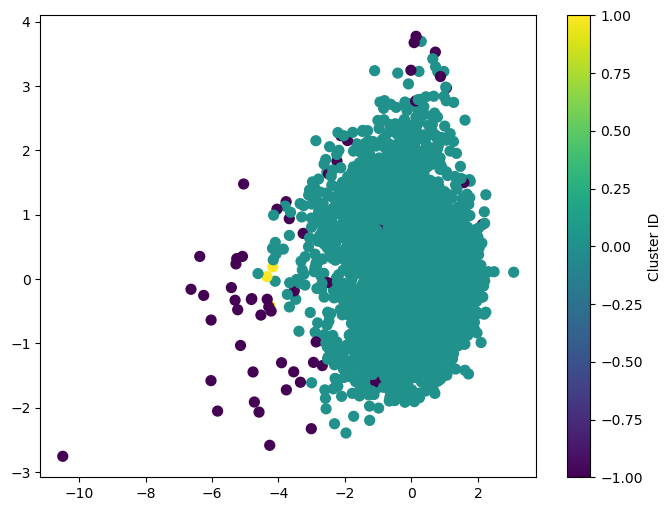

In [72]:
# plot DBSCAN

plt.figure(figsize=(8,6))
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=db_labels, cmap='viridis', s=50)
plt.colorbar(label='Cluster ID')

In [73]:
# step h-1 : define a function (Search for K)
from sklearn.cluster import KMeans 
from sklearn.metrics import silhouette_score
import  matplotlib.pyplot as plt

def k_search(X, k_range=range(2,11)):
    wcss, sils = [], []
    
    for k in k_range:                    # loop through the range of k
        km = KMeans(
            n_clusters= k,
            init = "k-means++",          # First centroid start start far apart 
            n_init= "auto",
            random_state= 42,
            algorithm = "lloyd",
        )
        preds = km.fit_predict(X)           # runs the algorithm & returns a cluster id for each patient
        wcss.append(km.inertia_)            # Elbows tension inside clusters  AKA rubber band effect 
        sils.append(silhouette_score(X, preds))  # Silhouteee hows seperate & compact each point is 
    return wcss, sils

Text(0, 0.5, 'WCSS')

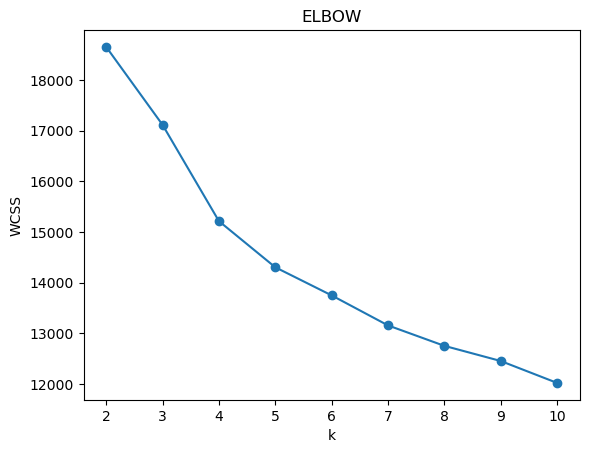

In [74]:
# step h-ii : Plot our elbow and silhouteee
wcss , sils = k_search(X_reduced)

plt.figure; plt.plot(range(2,11), wcss, 'o-')
plt.title("ELBOW")
plt.xlabel("k"); plt.ylabel("WCSS")

Text(0, 0.5, 'silhoutee score')

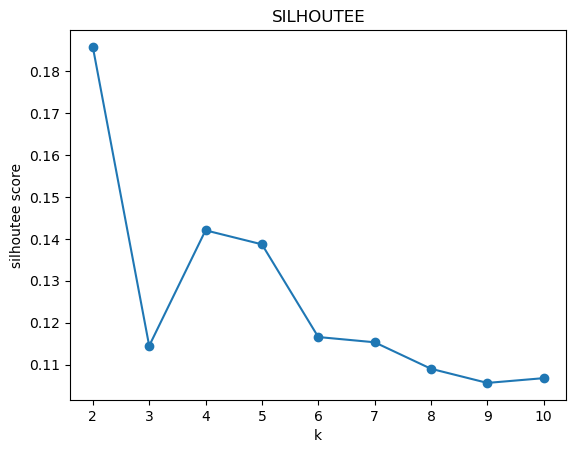

In [75]:
# step h-iii plotting the silhoutee

plt.figure; plt.plot(range(2,11),sils, 'o-')
plt.title("SILHOUTEE")
plt.xlabel("k"); plt.ylabel("silhoutee score")

In [76]:
# step h-iv Choose our k = 4

import numpy as np
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.neighbors import NearestNeighbors


k_OPT = 3
k_means = KMeans(
    n_clusters=k_OPT, n_init="auto",
    random_state=42, algorithm="lloyd"
)
clusters = k_means.fit_predict(X_reduced)

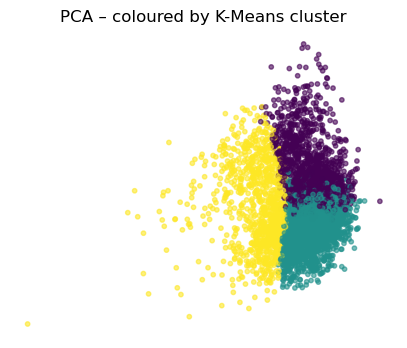

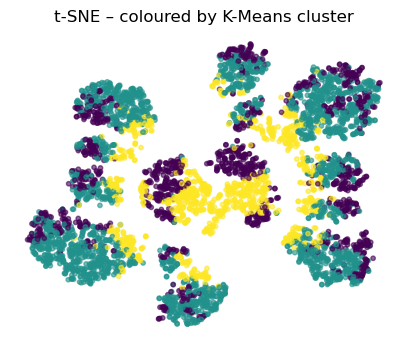

In [77]:
# ---------------- PCA / t-SNE visual -----------------------
from sklearn.decomposition import PCA
from sklearn.manifold      import TSNE

pca2  = PCA(n_components=2, random_state=42).fit_transform(X_reduced)
tsne2 = TSNE(n_components=2, perplexity=40,
             init="pca", random_state=42).fit_transform(X_reduced)

def scatter_2d(mat, labels, title):
    plt.figure(figsize=(5, 4))
    plt.scatter(mat[:, 0], mat[:, 1], c=labels, alpha=0.6, s=10)
    plt.title(title); plt.axis("off")

scatter_2d(pca2,  clusters, "PCA – coloured by K-Means cluster")
scatter_2d(tsne2, clusters, "t-SNE – coloured by K-Means cluster")